## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [1]:
!pip install -U pip qiskit[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 6.5 MB 28.2 MB/s 
     |████████████████████████████████| 18.0 MB 314 kB/s 
     |████████████████████████████████| 240 kB 56.5 MB/s 
     |████████████████████████████████| 198 kB 61.4 MB/s 
     |████████████████████████████████| 162 kB 73.2 MB/s 
     |████████████████████████████████| 112 kB 42.2 MB/s 
     |████████████████████████████████| 54 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 38.6 MB/s 
     |████████████████████████████████| 943 kB 47.5 MB/s 
     |████████████████████████████████| 38.1 MB 6.4 MB/s 
     |████████████████████████████████| 49 kB 5.8 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 4.0 MB 36.6 MB/s 
     |████████████████████████████████

In [2]:
#!pip install qiskit-aer-gpu

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# import os
import time
import numpy as np
from numpy.random import default_rng

import qiskit
import pylatexenc
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.extensions import Initialize
from qiskit.algorithms import optimizers

### 1-2. Setting of the main hyper-parameters of the model

In [4]:
BATCH_SIZE = 100
n_qubits = 3
n_params = 12
n_shots = 1024
iteration = 100
n_epochs = 30
n_layers = 1    # Number of random layers

SAVE_PATH = "aeqis/" # Data saving folder
seed = 2022
np.random.seed(seed)        # Seed for NumPy random number generator
rng = default_rng(seed)
qiskit.utils.algorithm_globals.random_seed = seed

isReal = False # 'True' for real device or 'False' for simulator
use_gpu = False

## 2. Construct Quantum Circuit

### 2-1. One Qubit Unitary Circuit 

In [5]:
def one_qubit_unitary(params, wire):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '1 Qubit Unitary')

  circ.rx(params[0],wire)
  circ.ry(params[1],wire)
  circ.rz(params[2],wire)
  
  return circ

'''
params = np.arange(0, 3)
one_qubit_unitary(params, 0).draw(output='mpl')
'''

"\nparams = np.arange(0, 3)\none_qubit_unitary(params, 0).draw(output='mpl')\n"

### 2-2. Two Qubits Unitary Circuit

In [6]:
def two_qubit_unitary(params, wires):  # need 3 parameters
  circ = QuantumCircuit(n_qubits, 1, name = '2 Qubit Unitary')
  '''
  circ.compose(one_qubit_unitary(params[0:3], wires[0]), inplace=True)
  circ.compose(one_qubit_unitary(params[3:6], wires[1]), inplace=True)
  circ.rzz(params[6], wires[0], wires[1])
  circ.ryy(params[7], wires[0], wires[1])
  circ.rxx(params[8], wires[0], wires[1])
  '''
  circ.rzz(params[0], wires[0], wires[1])
  circ.ryy(params[1], wires[0], wires[1])
  circ.rxx(params[2], wires[0], wires[1])
  #circ.compose(one_qubit_unitary(params[9:12], wires[0]), inplace=True)
  #circ.compose(one_qubit_unitary(params[12:15], wires[1]), inplace=True)
  circ.barrier()

  return circ

'''
params = np.arange(0, 15)
two_qubit_unitary(params, [0,1]).draw(output='mpl')
'''

"\nparams = np.arange(0, 15)\ntwo_qubit_unitary(params, [0,1]).draw(output='mpl')\n"

### 2-3. Decoder Circuit

In [7]:
def decoder(params, wires):  # need 12 parameters
  dec = QuantumCircuit(n_qubits, 1, name = '3 Qubit Unitary')
  dec.compose(one_qubit_unitary(params[0:3], [wires[0]]), inplace=True)
  dec.compose(one_qubit_unitary(params[3:6], [wires[1]]), inplace=True)
  dec.compose(one_qubit_unitary(params[6:9], [wires[2]]), inplace=True)

  dec.barrier()

  dec.compose(two_qubit_unitary(params[9:12], [wires[0],wires[1]]), inplace=True)
  dec.compose(two_qubit_unitary(params[9:12], [wires[1],wires[2]]), inplace=True)
  dec.compose(two_qubit_unitary(params[9:12], [wires[0],wires[2]]), inplace=True)

  dec.cx(wires[0], wires[1])
  dec.cx(wires[2], wires[1])
  #dec.barrier()

  #dec.measure(n_qubits//2, 0)   
  #circ.barrier()

  return dec

'''
params = np.arange(0, 12)
decoder(params, [0,1,2]).draw(output='mpl')
'''

"\nparams = np.arange(0, 12)\ndecoder(params, [0,1,2]).draw(output='mpl')\n"

### 2-4. Encoder Circuit

In [8]:
# Defining Encoder circuit. Encoder is inversion of Decoder.
def encoder(decoder):
    enc = QuantumCircuit(n_qubits, 1, name = 'Encoder')
    enc = decoder.inverse()
    
    return enc

'''
# visualizing Encoder to check
params = np.arange(0, 12)
encoder(decoder(params, np.arange(0,3))).draw(output='mpl')
'''

"\n# visualizing Encoder to check\nparams = np.arange(0, 12)\nencoder(decoder(params, np.arange(0,3))).draw(output='mpl')\n"

### 2-5. Noise Model

In [44]:
'''
circ = QuantumCircuit(3,1)
x_p = 0.2
z_p= 0.3
xz_p = 0.5
'''

def noise_circuit(type):
    circ = QuantumCircuit(n_qubits,1)
    #p = x_p + z_p + xz_p
    #print(f"bit flip 확률:{x_p}\nphase flip 확률:{z_p}\nbit and phase flip 확률 :{xz_p},\nIdentitiy(non error):{1-p}")
    
    #a = rng.choice(np.arange(1, 5), p=[x_p, z_p, xz_p,1-p ])
    if type == 1:
        circ.x(1)
    elif type == 2:
        circ.z(1)
    elif type == 3:
        circ.x(1)
        circ.z(1)
    elif type == -1:
        pass
    return circ

def noise_circuit_m(type):
  circ = QuantumCircuit(n_qubits,1)
    #p = x_p + z_p + xz_p
    #print(f"bit flip 확률:{x_p}\nphase flip 확률:{z_p}\nbit and phase flip 확률 :{xz_p},\nIdentitiy(non error):{1-p}")
    
    #a = rng.choice(np.arange(1, 5), p=[x_p, z_p, xz_p,1-p ])
  if type == 1:
    circ.x(1)
  elif type == 2:
    circ.z(1)
  elif type == 3:
    circ.x(1)
    circ.z(1)
  elif type == -1:
    pass
  circ.measure(1,0)

  return circ

#random_circuit(1,x_p,z_p,xz_p).draw()

### 2-6. Complete Circuit

In [27]:
def qae(params, wires, input_state, error_qubit, noise_type):  # need 90 parameters
  qc = QuantumCircuit(n_qubits, 1, name = 'Quantum Autoencoder')
  qc.append(input_state, [n_qubits//2])
  qc.barrier()

  dec = decoder(params, np.arange(0,n_qubits))
  qc.compose(encoder(dec), inplace=True)

  # Add noise
  # qc.barrier()
  # qc += noisemodel(error_qubit)
  
  qc.barrier()
  qc.compose(noise_circuit(noise_type),inplace=True)
  qc.barrier()
  
  qc.compose(dec, inplace=True)

  qc.barrier()
  #qc.measure(np.arange(0,9), np.arange(0,9))
  qc.measure(n_qubits//2,0)

  return qc

'''
params = np.arange(0, 15)
wires = np.arange(0,n_qubits)
initial_state = [0, 1]
input_state = Initialize(initial_state)
qae(params, wires, input_state, 1).draw(output='mpl')
'''

"\nparams = np.arange(0, 15)\nwires = np.arange(0,n_qubits)\ninitial_state = [0, 1]\ninput_state = Initialize(initial_state)\nqae(params, wires, input_state, 1).draw(output='mpl')\n"

## 3. Validate

### 3-1. Generalize Output

In [11]:
def gen_states(output_state, target_state):
  '''
  alpha = 0
  for i in range(16):
    alpha += np.sum(np.power([abs(output_state[32*i+j]) for j in range(16)],2))
  alpha = np.sqrt(alpha)
    
  if alpha == 0:
    for i in range(16):
      beta += np.power([abs(output_state[32*i+16+j]) for j in range(16)], 2)
    beta = np.sqrt(beta)

  else:
    pseudo_alpha = 0
    for i in range(16):
      beta += np.sum([output_state[32*i+16+j] for j in range(16)])
      pseudo_alpha += np.sum([output_state[32*i+j] for j in range(16)])
    beta = beta / pseudo_alpha * alpha
    '''
  alpha = output_state['0'] / (output_state['0'] + output_state['1'])
  beta = output_state['1'] / (output_state['0'] + output_state['1'])
    
  a, b = target_state[0], target_state[1]
  a = np.power(a,2) / (np.power(a,2) + np.power(b,2))
  b = np.power(b,2) / (np.power(a,2) + np.power(b,2))
    
  return np.array([alpha, beta]), np.array([a, b])

### 3-2. Configuring Qiskit Backend

In [12]:
if isReal:
  #from qiskit.providers.ibmq
  backend = qml.device("qiskit.ibmq", wires=n_qubits)
else:
  from qiskit.providers.aer import AerSimulator
  #backend = AerSimulator(method='statevector')
  from qiskit import Aer
  backend = AerSimulator(method="statevector")
  if use_gpu:
    #backend.available_devices()
    backend.set_options(device='GPU')

### 3-3. Import Pre-trained Parameters

In [18]:
params = [8.27639096, 5.51790211, 5.7056979, 1.4326275, 3.1257751, 5.64625242,
                  7.08448521, 6.45104003, 5.53609478, 5.57675776, 5.51595093, 5.64295498]

print("Parameters:")
print(initial_params)

Parameters:
[8.27639096, 5.51790211, 5.7056979, 1.4326275, 3.1257751, 5.64625242, 7.08448521, 6.45104003, 5.53609478, 5.57675776, 5.51595093, 5.64295498]


### 3-4. Get Counts

In [76]:
inputs = [Initialize([1,0]),Initialize([0,1])]

result = {'0':0, '1':0}
noise = {'0':0, '1':0}

for input in inputs:
  qc_x = qae(params, np.arange(0,n_qubits), input, 1, 1)
  qc_z = qae(params, np.arange(0,n_qubits), input, 1, 2)
  qc_xz = qae(params, np.arange(0,n_qubits), input, 1, 3)

  noise_x = noise_circuit_m(1)
  noise_z = noise_circuit_m(2)
  noise_xz = noise_circuit_m(3)

  # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
  result_x = execute(qc_x, backend).result()
  output_x = result_x.get_counts()
  if '0' in output_x:
    result['0'] += output_x['0'] * 2
  if '1' in output_x:
    result['1'] += output_x['1'] *2
  error_x = execute(noise_x, backend).result().get_counts()
  if '0' in error_x:
    noise['0'] += error_x['0'] * 2
  if '1' in error_x:
    noise['1'] += error_x['1'] * 2

  result_z = execute(qc_z, backend).result()
  output_z = result_z.get_counts()
  if '0' in output_z:
    result['0'] += output_z['0'] * 3
  if '1' in output_z:
    result['1'] += output_z['1'] * 3
  error_z = execute(noise_z, backend).result().get_counts()
  if '0' in error_z:
    noise['0'] += error_z['0'] * 3
  if '1' in error_z:
    noise['1'] += error_z['1'] * 3

  result_xz = execute(qc_xz, backend).result()
  output_xz = result_xz.get_counts()
  result['0'] += output_xz['0']
  if '0' in output_xz:
    result['0'] += output_xz['0'] * 5
  if '1' in output_xz:
    result['1'] += output_xz['1'] * 5
  error_xz = execute(noise_xz, backend).result().get_counts()
  if '0' in error_xz:
    noise['0'] += error_xz['0'] * 5
  if '1' in error_xz:
    noise['1'] += error_xz['1'] * 5

## 4. Plot Results for Comparison

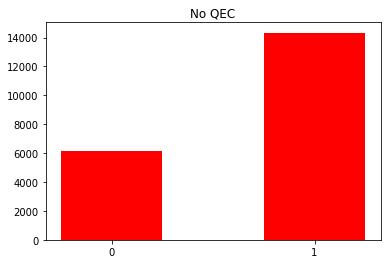

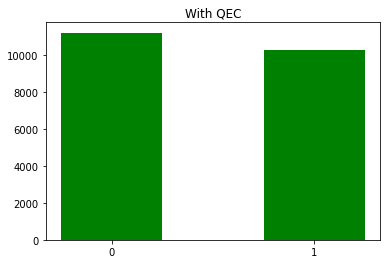

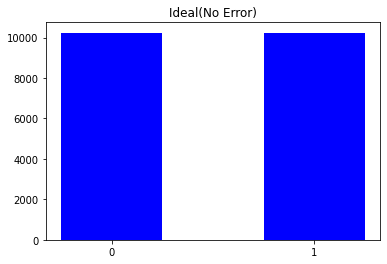

<Figure size 432x288 with 0 Axes>

In [77]:
# function to plot results for comparison 
def plot_result(result, noise, ideal):
    plt.bar(noise.keys(),noise.values(), width=0.5, color='r')
    plt.title('No QEC')
    plt.figure()

    plt.bar(result.keys(), result.values(), width=0.5, color='g')
    plt.title('With QEC')
    plt.figure()

    plt.bar(ideal.keys(), ideal.values(), width=0.5, color='b')
    plt.title('Ideal(No Error)')
    plt.figure()

    plt.show()

plot_result(result, noise, {'0':10240, '1':10240})